In [2]:
import math
import pandas as pd
import numpy as np
import random
from scipy.interpolate import UnivariateSpline
from scipy.stats import rankdata
from scipy.special import logit as logit
from matplotlib import pyplot as plt

from cdlib import algorithms, viz
import community as community_louvain
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import k_clique_communities,label_propagation_communities, asyn_lpa_communities,greedy_modularity_communities
from networkx.algorithms.centrality import *
from networkx.algorithms.cluster import *
# import igraph as ig

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
 
from xgboost import XGBClassifier
import seaborn as sns
from Powerset import *

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'
id_symbol_lookup_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\Hugo_Symbol_to_id.csv'
# filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\union_genes_4803.csv'

# Gene network generation (weighted-> unweighted)

In [9]:
# df = pd.read_csv(filterd_data).drop(columns = ['ID']).T
# correlations = np.corrcoef(df, df)[:4803, :4803]
# for i in range(correlations.shape[0]):
#     correlations[i][i]=0
# for i in range(correlations.shape[0]):
#     for j in range(correlations.shape[0]):
#         if correlations[i][j] < 0.1 and correlations[i][j]>-0.1:
#             correlations[i][j]  = 0
#         else:
#             correlations[i][j]  = 1
# correlations

# G = nx.Graph()
# G.add_nodes_from(np.arange(4803))
# G.nodes()
# edge_list = []
# for i in range(correlations.shape[0]):
#      for j in range(i+1, correlations.shape[0]):
#             if correlations[i][j] == 1:
#                 edge_list.append((i,j))

# len(edge_list)
# G.add_edges_from(edge_list)
# G.remove_nodes_from(list(nx.isolates(G)))
# G.number_of_nodes()

def const_net(correlation, threshold):
    correlations = np.copy(correlation)
    for i in range(correlations.shape[0]):
        correlations[i][i]=0
    for i in range(correlations.shape[0]):
        for j in range(correlations.shape[0]):
            if correlations[i][j] < threshold and correlations[i][j]>-threshold:
                correlations[i][j]  = 0
            else:
                correlations[i][j]  = 1

    G = nx.Graph()
    G.add_nodes_from(np.arange(correlations.shape[0]))
    edge_list = []
    for i in range(correlations.shape[0]):
         for j in range(i+1, correlations.shape[0]):
                if correlations[i][j] == 1:
                    edge_list.append((i,j))

    print(len(edge_list))
    G.add_edges_from(edge_list)
    G.remove_nodes_from(list(nx.isolates(G)))
    return G
  

In [94]:
a = np.arange(8)
a = np.delete(a, np.where(a == 2))
a = np.delete(a, np.where(a == 2))
a

array([0, 1, 3, 4, 5, 6, 7])

In [13]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]
print(correlations.shape)
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0.5 and correlations[i][j]>-0.5:
            correlations[i][j]  = 0
        else:
            correlations[i][j]  = 1
#             nodes =  np.delete(nodes, np.where(nodes == i))
#             nodes =  np.delete(nodes, np.where(nodes == j))
print(correlations)

G = nx.Graph()
# nodes = np.setdiff1d( np.arange(4803),nodes)
# G.add_nodes_from(nodes)
G.add_nodes_from(np.arange(4803))

edge_list = []

for i in range(correlations.shape[0]):
     for j in range(i+1, correlations.shape[0]):
            if correlations[i][j] == 1:
                edge_list.append((i,j))

print(len(edge_list))
G.add_edges_from(edge_list)
G.remove_nodes_from(list(nx.isolates(G)))

print(G.number_of_nodes())
com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works

m = com.link_modularity()
print(m)

In [17]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

coms = []
modularities = []
for thre in np.arange(0.5, 0.6, 0.01):
    print(thre)
    G = const_net(correlations, thre)
    print(G.number_of_nodes())
    com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works
    coms.append(com)
    m = com.link_modularity()
    print(m)
    modularities.append(m)
print(modularities)

# com = algorithms.lais2(G)# take loooong time
# com = algorithms.conga(G, number_communities=7) # take loooong time
#     com = algorithms.demon(G, min_com_size=10, epsilon=0.25) # works
#     com = algorithms.node_perception(G, threshold=0.25, overlap_threshold=0.25) #works longer time
# com = algorithms.lfm(G, alpha=1) # loong time

# coms = algorithms.egonet_splitter(G)
# coms = algorithms.angel(G, min_com_size=3, threshold=0.25) # min_community_size – minimum community size, default 3.
# coms = algorithms.big_clam(G) 
# coms = algorithms.danmf(G) # complex model
# com = algorithms.kclique(G, k=3) #k – Size of smallest clique
# coms = algorithms.slpa(G)
# coms = algorithms.percomvc(G)
# com = algorithms.overlapping_seed_set_expansion(G) # complex model
# coms = algorithms.node_perception(G, threshold=0.25, overlap_threshold=0.25)
# coms = algorithms.nnsed(G)
# coms = algorithms.nmnf(G) #complex model
# coms = algorithms.lemon(G, seeds, min_com_size=20, max_com_size=50) #complex model
# com = algorithms.congo(G, number_communities=3, height=2) # number_communities – the number of communities desired.height – The lengh of the longest shortest paths that CONGO considers, default 2

0.5
188522
4071
FitnessResult(min=None, max=None, score=0.22012300792384745, std=None)
0.51
169098
3979
FitnessResult(min=None, max=None, score=0.2417357284473682, std=None)
0.52
151640
3857
FitnessResult(min=None, max=None, score=0.23993355514312, std=None)
0.53
135967
3748
FitnessResult(min=None, max=None, score=0.2605213196686659, std=None)
0.54
122126
3619
FitnessResult(min=None, max=None, score=0.2722639799519779, std=None)
0.55
109703
3491
FitnessResult(min=None, max=None, score=0.22737862230893824, std=None)
0.56
98622
3379
FitnessResult(min=None, max=None, score=0.20021895254010327, std=None)
0.5700000000000001
88759
3269
FitnessResult(min=None, max=None, score=0.1638006893246137, std=None)
0.5800000000000001
79930
3133
FitnessResult(min=None, max=None, score=0.1612551610240643, std=None)
0.5900000000000001
71876
3006
FitnessResult(min=None, max=None, score=0.15252955357608233, std=None)
[FitnessResult(min=None, max=None, score=0.22012300792384745, std=None), FitnessResult(min=

In [57]:
com = coms[4]
com.to_node_community_map()
# 11 clusters: 0-10

defaultdict(list,
            {2: [0, 1, 2, 3, 4, 5, 6],
             4: [0, 1, 2, 3, 4, 5, 6, 7],
             12: [0, 3, 4, 5],
             17: [0, 1, 2, 3, 4, 5, 6, 7, 8],
             24: [0, 3, 4, 5],
             25: [0, 1, 2, 3],
             26: [0, 1, 2, 3, 4],
             27: [0, 1, 2, 3, 4],
             31: [0, 1, 2, 3, 4, 5, 6, 7, 8],
             32: [0, 1, 2, 3, 4],
             33: [0, 1, 2, 3, 4],
             35: [0, 1, 2, 3, 4],
             38: [0, 1, 2, 3],
             40: [0, 1, 2, 3, 4, 5, 6, 8],
             41: [0, 1, 2, 3, 4],
             42: [0, 1, 2, 3, 4, 5, 6],
             46: [0, 1, 2, 3, 4, 5, 6, 8],
             47: [0, 1, 2, 3, 4, 5, 6, 8],
             49: [0, 1, 2, 3],
             50: [0, 1, 2, 3, 4],
             51: [0, 1, 2, 3, 4],
             53: [0, 1, 2, 3, 4, 5, 6],
             54: [0, 1, 2, 3, 4, 5, 6],
             55: [0, 1, 3, 4, 5],
             58: [0, 1, 2, 3, 4],
             60: [0, 1, 2, 3, 4, 5, 6],
             62: [0, 1, 2

In [59]:

# print(conmmunities[10]) 
# https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx


[1032, 1814, 2239, 3292, 3454, 3543, 3783, 4069, 4077, 4111, 4189, 4197, 4280, 4365, 4484, 4713, 4784, 3464, 3792, 4579, 4701, 2859, 4250, 4373, 4586, 4302, 4762, 3794, 4195, 4635, 803, 1590, 1752, 2084, 2631, 2698, 2842, 2940, 3035, 3131, 3171, 3350, 3359, 3363, 3389, 3415, 3426, 3562, 3574, 3578, 3635, 3711, 3717, 3734, 3739, 3749, 3758, 3807, 3839, 3904, 3911, 3912, 3963, 3973, 3997, 4005, 4009, 4010, 4026, 4049, 4050, 4062, 4063, 4087, 4088, 4119, 4122, 4127, 4130, 4177, 4191, 4252, 4276, 4288, 4321, 4324, 4325, 4359, 4380, 4389, 4395, 4404, 4405, 4411, 4413, 4414, 4450, 4466, 4471, 4473, 4482, 4486, 4504, 4509, 4512, 4539, 4541, 4545, 4550, 4555, 4565, 4577, 4587, 4599, 4602, 4619, 4625, 4627, 4632, 4637, 4645, 4649, 4663, 4665, 4676, 4681, 4683, 4699, 4708, 4711, 4732, 4733, 4734, 4749, 4755, 4757, 4760, 4788]


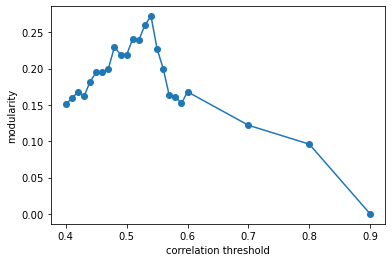

In [5]:
# 0.3 :1640970 4803
# 0.4 :573764 4745 FitnessResult(min=None, max=None, score=0.15127569396624832, std=None)
# 0.5 :188522 4071 FitnessResult(min=None, max=None, score=0.21970101429567895, std=None)
# 0.51 169098 3979 FitnessResult(min=None, max=None, score=0.2417357284473682, std=None)
# 0.52 151640 3857 FitnessResult(min=None, max=None, score=0.23993355514312, std=None)
# 0.53 135967 3748 FitnessResult(min=None, max=None, score=0.2605213196686659, std=None)
# 0.54 122126 3619 FitnessResult(min=None, max=None, score=0.2722639799519779, std=None) 2886 nodes
# 0.55 109703 3491 FitnessResult(min=None, max=None, score=0.22737862230893824, std=None)
# 0.56 98622 3379 FitnessResult(min=None, max=None, score=0.20021895254010327, std=None)
# 0.57 88759 3269 FitnessResult(min=None, max=None, score=0.1638006893246137, std=None)
# 0.58 79930 3133 FitnessResult(min=None, max=None, score=0.1612551610240643, std=None)
# 0.59 71876 3006 FitnessResult(min=None, max=None, score=0.15252955357608233, std=None)
# 0.6 :64496 2886FitnessResult(min=None, max=None, score=0.16896384714919208, std=None)
# 0.7 :21395 1553 FitnessResult(min=None, max=None, score=0.12196361112524495, std=None)
# 0.8 :4460 664 FitnessResult(min=None, max=None, score=0.0964465467565242, std=None)
# 0.9 :172 116 FitnessResult(min=None, max=None, score=0.0, std=None)
# 0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49

# 0.159, 0.168,0.162,0.182,0.189,0.195,0.20,0.23 0.219

thresholds_list = [0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.7,0.8,0.9]
modularities = [0.151,0.159, 0.168,0.162,0.182,0.195,0.195,0.20,0.23, 0.219,0.219,0.241,0.239, 0.260, 0.272, 0.227, 0.200,0.163,0.1612551,0.152,0.168,0.122,0.096,0]

plt.figure()
plt.xlabel('correlation threshold')
plt.ylabel('modularity')
plt.plot(thresholds_list, modularities)
plt.scatter(thresholds_list, modularities)
plt.show()

# With threshold 0.54

In [10]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

thre = 0.54
G = const_net(correlations, thre)
print(G.number_of_nodes())
com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works
m = com.link_modularity()
print(m)


122126
3619
FitnessResult(min=None, max=None, score=0.2755406590595339, std=None)


In [94]:
clusters = com.to_node_community_map()
clusters

d = {}

for keys in clusters: 
    d[keys] = tuple(clusters[keys])
    clusters[keys] = tuple(clusters[keys])
d

{0: (0, 2),
 2: (0, 1, 2, 4, 6, 7),
 4: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 12: (0, 1, 2, 3, 6),
 17: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 19: (0, 2),
 23: (0, 1, 2, 5, 6, 7, 8),
 24: (0, 1, 2, 3, 6),
 26: (0, 1, 2, 3, 5),
 27: (0, 1, 2, 3, 4, 5),
 31: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 32: (0, 1, 2, 3, 4, 5),
 33: (0, 1, 2, 3, 4, 5),
 35: (0, 1, 2, 3, 4, 5, 6),
 38: (0, 1, 2, 3, 5),
 40: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 41: (0, 1, 2, 3, 4, 5),
 42: (0, 1, 2, 3, 4, 6, 7),
 46: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 47: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 49: (0, 1, 2, 3, 5),
 50: (0, 1, 2, 3, 4, 5),
 51: (0, 1, 2, 3, 4, 5, 6),
 53: (0, 1, 2, 3, 4, 6, 7),
 54: (0, 1, 2, 4, 6),
 55: (0, 1, 2, 3, 6),
 58: (0, 1, 2, 3, 4, 5),
 60: (0, 1, 2, 3, 4, 6, 7),
 61: (0, 1, 2),
 62: (0, 1, 2, 3, 4, 5),
 64: (0, 2, 6),
 66: (0, 1, 2, 3, 5),
 68: (0, 1, 2, 3, 4, 5, 6, 7, 8),
 69: (0, 1, 2, 3, 4, 5, 6),
 70: (0, 1, 2, 3, 4, 5),
 71: (0, 1, 2, 3),
 73: (0, 1, 2, 3, 4, 5),
 75: (0, 1, 2, 3, 5),
 76: (0,),
 79: (0, 1, 2, 3),
 80: (0, 1, 2,

In [83]:
clusters = com.to_node_community_map() #2885 nodes
# print(clusters)
# print(clusters[0])
# len(clusters)
combines = []
# print(clusters)
for i in range(len(clusters)):
    if clusters[i] not in combines and clusters[i]!=[]:
        combines.append(clusters[i])
len(combines) #305

305

In [84]:
ct_list = []
for j in combines:
    ct = 0
    for i in range(len(clusters)):
        if clusters[i] == j:
            ct +=1
    ct_list.append(ct)
print(sum(ct_list))

2682


Counter({(0, 2): 10,
         (): 1128,
         (0, 1, 2, 4, 6, 7): 4,
         (0, 1, 2, 3, 4, 5, 6, 7, 8): 618,
         (1, 3): 22,
         (0, 1, 2, 3, 6): 9,
         (0, 1, 2, 5, 6, 7, 8): 2,
         (1, 2, 3): 8,
         (0, 1, 2, 3, 5): 56,
         (0, 1, 2, 3, 4, 5): 76,
         (2, 3): 8,
         (0, 1, 2, 3, 4, 5, 6): 51,
         (0, 1, 2, 3, 4, 6, 7): 8,
         (0, 1, 2, 4, 6): 1,
         (0, 1, 2): 3,
         (3,): 38,
         (0, 2, 6): 2,
         (0, 1, 2, 3): 20,
         (0,): 12,
         (0, 1, 2, 3, 4, 5, 6, 7): 80,
         (1, 2, 3, 5): 2,
         (0, 1, 3): 6,
         (0, 1, 2, 3, 4, 6): 7,
         (1, 2): 2,
         (0, 1, 2, 6): 6,
         (1, 2, 3, 6): 2,
         (1, 3, 6): 3,
         (0, 1, 2, 3, 4, 5, 7, 8): 5,
         (0, 1, 2, 3, 6, 7, 8): 4,
         (0, 1, 2, 3, 5, 8): 2,
         (0, 1, 2, 3, 5, 6): 15,
         (0, 1, 2, 3, 5, 6, 7): 3,
         (1, 2, 5, 6): 3,
         (0, 2, 3, 6): 1,
         (1, 3, 5): 3,
         (0, 1, 2, 3

In [253]:
# clusters = com.to_node_community_map()
# conmmunities = []
# for i in range(11):
#     conmmunities.append([])


# for i in clusters.keys():
#     c = clusters[i]
#     for j in c:
#         conmmunities[j].append(i)

# viz.plot_network_clusters(G, com, node_size = 20 )

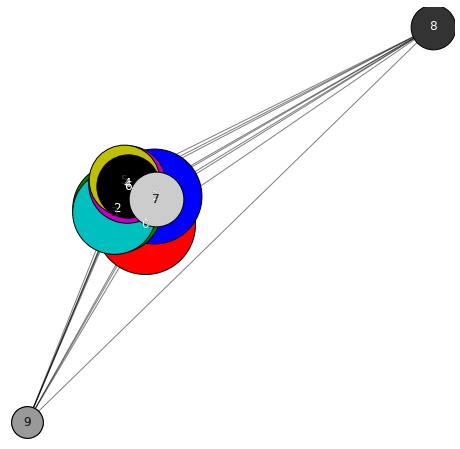

In [251]:
viz.plot_community_graph(G, com,plot_overlaps=True,node_size = 1000, plot_labels = True)

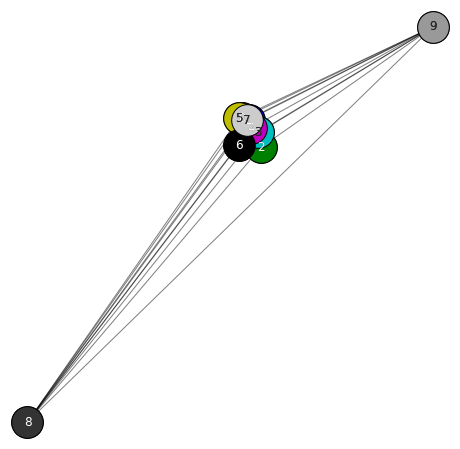

In [252]:
viz.plot_community_graph(G, com,node_size = 1000, plot_labels = True)

# previous work


patient network

In [133]:
df = pd.read_csv(filterd_data).drop(columns = ['Hugo_ID']).T
correlations = np.corrcoef(df, df)[:231, :231]
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
            
ex_df = pd.DataFrame(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])



df = pd.DataFrame()
de = G.degree(weight='weight')
cc = nx.clustering(G,weight='weight')

df['weighted_degree'] = np.array(de).T[1][:]
df['weighted_clustering_coef'] = cc.values()


thres_media = np.median(correlations)
G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        if correlations[i,j] > thres_media:
            G.add_edge(i, j)
de = G.degree()
cc = nx.clustering(G)

df['degree'] = np.array(de).T[1][:]
df['clustering_coef'] = cc.values()      
df.round(3)
df
# df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv")

,weighted_degree,weighted_clustering_coef,degree,clustering_coef
0,71.354838,0.308534,55,0.847811
1,78.729485,0.357802,29,0.738916
2,124.557025,0.495771,147,0.692852
3,44.278808,0.231304,8,0.892857
4,77.967473,0.315042,61,0.900000
...,...,...,...,...
226,80.292323,0.347773,36,0.623810
227,68.041752,0.301884,26,0.800000
228,143.421151,0.520197,147,0.957227
229,42.040203,0.177857,24,0.855072


In [3]:
df = pd.read_csv(filterd_data)
df = df.drop(columns = ['Hugo_ID'])
cancer_types =  [0]*117+[1]*74+[2]*40
print(len(cancer_types))
# sns.countplot(x = 'Hugo_ID', data=df)


# df['cancer'] = cancer_types

correlations = np.corrcoef(df, df)[:133, :133]

for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
#         if correlations[i][j] < 0.2:
#             correlations[i][j]  = 0
#         correlations[i][j] = math.floor(correlations[i][j]*100)
correlations # weighted network matrix
# ex_df = pd.DataFrame(correlations)
# ex_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_matrix.csv")
# np_pos = np.zeros((133,133))
# np_neg = np.zeros((133,133))
# for i in range(correlations.shape[0]):
#     for j in range(correlations.shape[0]):
#         if correlations[i][j] > 0:
#             np_pos[i][j] = correlations[i][j] 
#         if correlations[i][j] < 0:
#             np_neg[i][j] = -correlations[i][j] 
# ex_df = pd.DataFrame(np_pos)
# ex_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_matrix_pos.csv")
# ex_df = pd.DataFrame(np_neg)
# ex_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_matrix_abs.csv")

231


array([[0.        , 0.74065188, 0.50100018, ..., 0.01460397, 0.23895306,
        0.01588378],
       [0.74065188, 0.        , 0.17325192, ..., 0.0707046 , 0.17785555,
        0.04636617],
       [0.50100018, 0.17325192, 0.        , ..., 0.00584516, 0.44585732,
        0.00200516],
       ...,
       [0.01460397, 0.0707046 , 0.00584516, ..., 0.        , 0.23463521,
        0.29402463],
       [0.23895306, 0.17785555, 0.44585732, ..., 0.23463521, 0.        ,
        0.45071698],
       [0.01588378, 0.04636617, 0.00200516, ..., 0.29402463, 0.45071698,
        0.        ]])

In [5]:

G = nx.Graph()
G.add_nodes_from(np.arange(133))
G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])
        

G.number_of_nodes()

133

In [36]:
# ccc = asyn_lpa_communities(G,weight='weight')
# next(ccc)
# greedy_modularity_communities(G,weight='weight' )


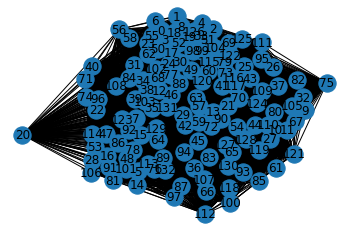

In [6]:

plt.subplot()
nx.draw(G, with_labels=True)
plt.show()

In [20]:

wc = algorithms.wCommunity(G, min_bel_degree=0.99999, threshold_bel_degree=0.99999, weightName='weight')

# wc
wc.to_json()
wc = algorithms.louvain(G,weight='weight',resolution=0.5)
print(wc.to_node_community_map())
print("--------------")
ccc = asyn_lpa_communities(G,weight='weight')
print(len(next(ccc)))
print("--------------")
gmc = greedy_modularity_communities(G,weight='weight' )
print(gmc)
print("--------------")
bp = community_louvain.best_partition(G,weight='weight', resolution=0.5)
print(bp)

'{"communities": [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]], "algorithm": "wCommunity", "params": {"min_bel_degree": 0.99999, "threshold_bel_degree": 0.99999, "weightName": "weight"}, "overlap": true, "coverage": 1.0}'

In [4]:
df = pd.DataFrame()
de = G.degree(weight='weight')
b = betweenness_centrality(G,weight = 'weight')
# print(b)
e = eigenvector_centrality(G,weight = 'weight')
# print(e)
i = information_centrality(G,weight = 'weight')
# print(i)
cc = nx.clustering(G,weight='weight')
df['degree'] = np.array(de).T[1][:]
df['clustering_coef'] = cc.values()
df['betweenness'] = b.values()
df['eigenvector'] = e.values()
df['closeness'] = i.values()
df.round(3)

,degree,clustering_coef,betweenness,eigenvector,closeness
0,37.068,0.185,0.107,0.128,0.104
1,25.771,0.153,0.000,0.086,0.090
2,36.064,0.182,0.006,0.128,0.103
3,35.926,0.183,0.000,0.125,0.103
4,35.315,0.181,0.000,0.125,0.102
...,...,...,...,...,...
128,25.487,0.138,0.023,0.052,0.089
129,31.071,0.172,0.012,0.073,0.097
130,17.225,0.112,0.015,0.034,0.073
131,36.866,0.211,0.000,0.102,0.104


In [5]:
# df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_features_133.csv")
df

,degree,clustering_coef,betweenness,eigenvector,closeness
0,37.068241,0.185392,0.107449,0.128421,0.104133
1,25.770810,0.152595,0.000000,0.086084,0.089725
2,36.063570,0.181958,0.006130,0.128194,0.102997
3,35.926064,0.182528,0.000000,0.125222,0.102907
4,35.315217,0.181160,0.000000,0.124995,0.102200
...,...,...,...,...,...
128,25.487240,0.138486,0.023479,0.051816,0.089273
129,31.070944,0.171599,0.012260,0.072824,0.097389
130,17.225014,0.111606,0.014573,0.033870,0.073226
131,36.865576,0.210740,0.000000,0.101698,0.104416


# Decision Tree


696
          0       1      2      3      4       5      6       7      8  \
0     8.693   1.164  0.243  0.106  3.038   9.665  0.000   2.725  0.000   
1     8.693   1.164  0.243  0.106  3.038   9.665  0.000   2.725  0.000   
2    22.395  32.202  0.392  0.141  0.185  20.991  0.000  12.568  0.094   
3    22.395  32.202  0.392  0.141  0.185  20.991  0.000  12.568  0.094   
4    50.843  58.076  0.418  0.291  0.295  26.276  0.453   0.812  0.046   
..      ...     ...    ...    ...    ...     ...    ...     ...    ...   
691  52.029  10.074  0.264  0.317  0.382   4.503  0.000   2.029  0.375   
692  52.029  10.074  0.264  0.317  0.382   4.503  0.000   2.029  0.375   
693  52.029  10.074  0.264  0.317  0.382   4.503  0.000   2.029  0.375   
694  52.029  10.074  0.264  0.317  0.382   4.503  0.000   2.029  0.375   
695  52.029  10.074  0.264  0.317  0.382   4.503  0.000   2.029  0.375   

          9  ...    124    125    126    127    128    129    130    131  \
0     4.329  ...  0.313  0.000 

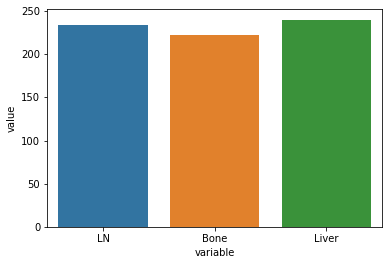

In [34]:
# with data balance
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

features_df = pd.read_csv(network_features)

genes_df = pd.read_csv(filterd_data)
df = genes_df.drop(columns = ['Hugo_ID'])
pt_np = np.array(df.T)
pt_np
new_np = np.repeat(pt_np[:117],2, axis=0) 
new_np = np.concatenate((new_np, np.repeat(pt_np[117:191],3, axis=0) ), axis=0)
new_np = np.concatenate((new_np, np.repeat(pt_np[191:],6, axis=0) ), axis=0)
df = pd.DataFrame(new_np)

cancer_types =  [0]*117*2+[1]*74*3+[2]*40*6

print(len(cancer_types))

df['cancer'] = cancer_types

print(df)

# sns.countplot(x = 'cancer', data=df)

class2idx = {
    0:0,
    1:1,
    2:2
}

idx2class = {v: k for k, v in class2idx.items()}

df['cancer'].replace(class2idx, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
ori_X = X.copy(deep=True)

def get_class_distribution(obj):
    count_dict = {
        "LN": 0,
        "Bone": 0,
        "Liver": 0
    } 
    for i in obj:
        if i == 0: 
            count_dict['LN'] += 1
        elif i == 1: 
            count_dict['Bone'] += 1
        elif i == 2: 
            count_dict['Liver'] += 1          
        else:
            print("Check classes.")          
    return count_dict
ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y)]).melt(),\
            x = "variable", y="value")



231


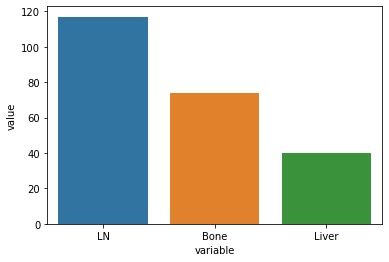

In [40]:
# without data balance
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

features_df = pd.read_csv(network_features)

genes_df = pd.read_csv(filterd_data)
df = genes_df.drop(columns = ['Hugo_ID'])

cancer_types =  [0]*117+[1]*74+[2]*40

print(len(cancer_types))
# sns.countplot(x = 'Hugo_ID', data=df)


df = df.T

# df['degree'] = list(features_df['degree'])
# df['clustering_coef'] = list(features_df['clustering_coef'])
# df['betweenness'] = list(features_df['betweenness'])
# df['eigenvector'] = list(features_df['eigenvector'])
# df['closeness'] = list(features_df['closeness'])



df['cancer'] = cancer_types
# print(df)

# sns.countplot(x = 'cancer', data=df)

class2idx = {
    0:0,
    1:1,
    2:2
}

idx2class = {v: k for k, v in class2idx.items()}

df['cancer'].replace(class2idx, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
ori_X = X.copy(deep=True)

def get_class_distribution(obj):
    count_dict = {
        "LN": 0,
        "Bone": 0,
        "Liver": 0
    } 
    for i in obj:
        if i == 0: 
            count_dict['LN'] += 1
        elif i == 1: 
            count_dict['Bone'] += 1
        elif i == 2: 
            count_dict['Liver'] += 1          
        else:
            print("Check classes.")          
    return count_dict
ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y)]).melt(),\
            x = "variable", y="value")





In [105]:
print(X.shape[1])

133


In [17]:
# # Training testing data splite

# class2idx = {
#     0:0,
#     1:1,
#     2:2
# }
# idx2class = {v: k for k, v in class2idx.items()}
# df['cancer'].replace(class2idx, inplace=True)
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]
# print(X,y)
# # Split train into train-val
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=21)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# print("Train set datapoints: "+str(len(X_train)))
# print("Validation set datapoints: "+str(len(X_val)))
# def get_class_distribution(obj):
#     count_dict = {
#         "LN": 0,
#         "Bone": 0,
#         "Liver": 0
#     } 
#     for i in obj:
#         if i == 0: 
#             count_dict['LN'] += 1
#         elif i == 1: 
#             count_dict['Bone'] += 1
#         elif i == 2: 
#             count_dict['Liver'] += 1          
#         else:
#             print("Check classes.")          
#     return count_dict
# ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(),\
#             x = "variable", y="value")
# ax.set(xlabel="Cancer type", ylabel = "Cases number", title="Class Distribution in Train Set")
# plt.show(ax)
# ax2 = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), \
#             x = "variable", y="value")
# ax2.set(xlabel="Cancer type", ylabel = "Cases number",title="Class Distribution in Validation Set")
# plt.show(ax2)

In [5]:


# print(X,y)

model = XGBClassifier()
# kfold = KFold(n_splits=10,shuffle=True)

results = cross_val_score(model, X, y, cv=10)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)


Accuracy: 93.50% (4.46%)
[[115   2   0]
 [  6  68   0]
 [  7   0  33]]


Feature: 0, Score: 0.01474
Feature: 1, Score: 0.00102
Feature: 2, Score: 0.02014
Feature: 3, Score: 0.00156
Feature: 4, Score: 0.01122
Feature: 5, Score: 0.00173
Feature: 6, Score: 0.00157
Feature: 7, Score: 0.01837
Feature: 8, Score: 0.00048
Feature: 9, Score: 0.00131
Feature: 10, Score: 0.00287
Feature: 11, Score: 0.04201
Feature: 12, Score: 0.00658
Feature: 13, Score: 0.00277
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00999
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00078
Feature: 20, Score: 0.00156
Feature: 21, Score: 0.01174
Feature: 22, Score: 0.01515
Feature: 23, Score: 0.00064
Feature: 24, Score: 0.00252
Feature: 25, Score: 0.00122
Feature: 26, Score: 0.00010
Feature: 27, Score: 0.00556
Feature: 28, Score: 0.02422
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00227
Feature: 31, Score: 0.02053
Feature: 32, Score: 0.19745
Feature: 33, Score: 0.00674
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00033
Fe

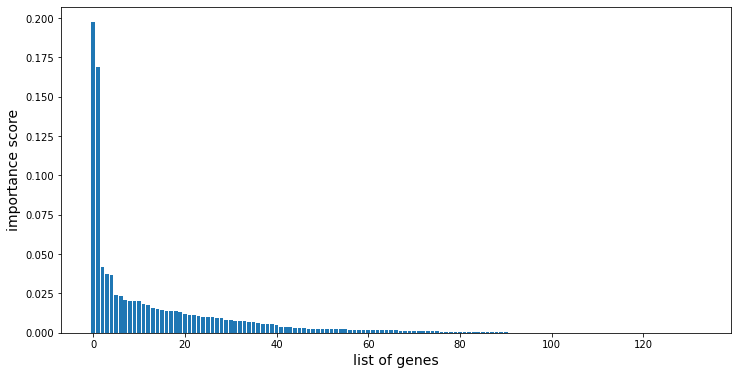

In [6]:
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], sorted(importance, reverse = True))
plt.ylabel('importance score', fontsize=14)
plt.xlabel('list of genes', fontsize=14)
plt.show()

[115, 236, 310, 1085, 1328, 1594, 1597, 1902, 3121, 4036, 5637, 6100, 7454, 9188, 12331]
[0.02014277, 0.018374829, 0.04200656, 0.015146018, 0.024216356, 0.020526273, 0.19745463, 0.03737781, 0.16880408, 0.020510497, 0.015868604, 0.017415376, 0.0236202, 0.036454737, 0.0210847]


Text(0.5, 0, 'list of genes')

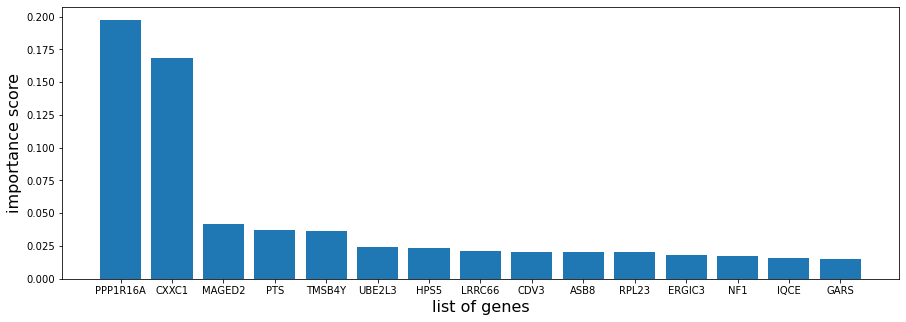

In [7]:
# sorted(importance[:133])
id_symbol_lookup_df = pd.read_csv(id_symbol_lookup_file)
top_genes = []
top_gene_importance = []
importance_threshold = sorted(importance,reverse=True)[15]
for i in range(len(genes_df)):
    if importance[i]>importance_threshold:
        top_genes.append(genes_df['Hugo_ID'][i])
        top_gene_importance.append(importance[i])

print(top_genes)
print(top_gene_importance)
# id_symbol_lookup_df
# print(list(id_symbol_lookup_df['ID']))
# print(list(id_symbol_lookup_df['Hugo_Symbol']))
ids = list(id_symbol_lookup_df['ID'])
symbols = list(id_symbol_lookup_df['Hugo_Symbol'])
top_genes_symbol = []
for i in top_genes:
    top_genes_symbol.append(symbols[i])

top_genes_df = pd.DataFrame({'Hugo_Symbol':top_genes_symbol,'importance':top_gene_importance}) 

top_genes_df = top_genes_df.sort_values(by='importance',axis=0,ascending=[False])

plt.figure(figsize=(15,5))
plt.bar(top_genes_df['Hugo_Symbol'], top_genes_df['importance'])
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)

In [96]:
# without data balance
# filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
# network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'
# features_df = pd.read_csv(network_features)
# genes_df = pd.read_csv(filterd_data)
# df = genes_df.drop(columns = ['Hugo_ID'])
# cancer_types =  [0]*117+[1]*74+[2]*40

# df = df.T
# df['cancer'] = cancer_types
# class2idx = {
#     0:0,
#     1:1,
#     2:2
# }
# idx2class = {v: k for k, v in class2idx.items()}
# df['cancer'].replace(class2idx, inplace=True)
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]
# ori_X = X.copy(deep=True)


# model = XGBClassifier()
# model.fit(X, y)
# # get importance
# importance = model.feature_importances_
# trace_list = list(range(len(importance)))
# genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
# # print(genes_df)
# genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
# sorted_index_by_importance = list(genes_df['index'])

# print(sorted_index_by_importance)
def drop_last_importance_gene(current_gene_X, drop_index):
    res_X = current_gene_X.drop(columns=[drop_index])
    return res_X

lp_acc = []
for lp in range(20):
    
    print("Loop "+str(lp))
    accs = []
    gene_taken_off_sequence = []
    
    
    features_df = pd.read_csv(network_features)
    genes_df = pd.read_csv(filterd_data)
    df = genes_df.drop(columns = ['Hugo_ID'])
    pt_np = np.array(df.T)
    new_np = np.repeat(pt_np[:117],2, axis=0) 
    new_np = np.concatenate((new_np, np.repeat(pt_np[117:191],3, axis=0) ), axis=0)
    new_np = np.concatenate((new_np, np.repeat(pt_np[191:],6, axis=0) ), axis=0)
    df = pd.DataFrame(new_np)
    cancer_types =  [0]*117*2+[1]*74*3+[2]*40*6
    df['cancer'] = cancer_types
    class2idx = {
        0:0,
        1:1,
        2:2
    }
    idx2class = {v: k for k, v in class2idx.items()}
    df['cancer'].replace(class2idx, inplace=True)
    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1]
    
    model = XGBClassifier()
    model.fit(X, y)
    # get importance
    importance = model.feature_importances_
    trace_list = list(range(len(importance)))
    genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
    # print(genes_df)
    genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
    sorted_index_by_importance = list(genes_df['index'])

    for i in range(130):
        last_important_gene_id = sorted_index_by_importance.pop(-1)
        gene_taken_off_sequence.append(last_important_gene_id)
        trace_list.remove(last_important_gene_id)
#         print(last_important_gene_id)
        X = drop_last_importance_gene(X, last_important_gene_id)
#         print(X.shape[1])
        model = XGBClassifier()
        kfold = KFold(n_splits=10,shuffle=True)
        results = cross_val_score(model, X, y, cv=kfold) # same data split for each loop
        print("Accuracy: %.2f%%" % (results.mean()*100))
        accs.append(results.mean())
        model = XGBClassifier()
        model.fit(X, y)
        # get importance
        importance = model.feature_importances_
        genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
        genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
        sorted_index_by_importance = list(genes_df['index'])
    lp_acc.append(accs)
    
#         print(sorted_index_by_importance)
    
#     y_pred = cross_val_predict(model, X, y, cv=10)
#     conf_mat = confusion_matrix(y, y_pred)
#     print(conf_mat)

Loop 0
Accuracy: 100.00%


KeyboardInterrupt: 

[0.93061594 0.91304348 0.92246377 0.91394928 0.92608696 0.91775362
 0.92192029 0.92246377 0.90507246 0.90434783 0.91793478 0.92626812
 0.9307971  0.92644928 0.92192029 0.92626812 0.92626812 0.91793478
 0.92663043 0.92699275 0.92228261 0.91775362 0.90942029 0.92228261
 0.92192029 0.92192029 0.93478261 0.9134058  0.9134058  0.91775362
 0.92626812 0.91811594 0.91757246 0.91376812 0.91304348 0.93514493
 0.9134058  0.91775362 0.91793478 0.93061594 0.93043478 0.92626812
 0.92192029 0.92246377 0.91757246 0.93061594 0.91304348 0.93514493
 0.93061594 0.92681159 0.91775362 0.92210145 0.9307971  0.92681159
 0.90923913 0.92644928 0.92626812 0.91358696 0.92663043 0.91322464
 0.92173913 0.9134058  0.91775362 0.91847826 0.93931159 0.92626812
 0.92228261 0.92644928 0.92228261 0.93496377 0.91376812 0.92644928
 0.92663043 0.93061594 0.92663043 0.91757246 0.9307971  0.92228261
 0.93097826 0.93478261 0.93478261 0.94402174 0.91322464 0.93496377
 0.93097826 0.93985507 0.93061594 0.92626812 0.93115942 0.9306

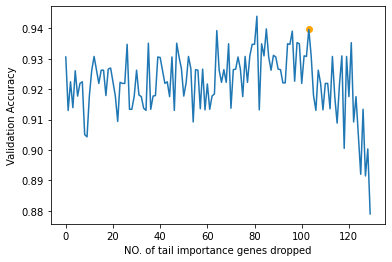

In [10]:
accs = np.mean(lp_acc,axis=0)
print(accs)
print(gene_taken_off_sequence)
plt.figure()
plt.xlabel('NO. of tail importance genes dropped')
plt.ylabel('Validation Accuracy')
plt.plot(np.arange(len(accs)), accs)
plt.scatter(103, accs[103], color = 'orange')
# plt.scatter(123, accs[123], color = 'y')
plt.show()
# drop_index = gene_taken_off_sequence[:-26] for good prediction. 
# drop_index = gene_taken_off_sequence[:-8] for testing patient net features

# Add patient network features
### need X result processed by above.

         0        2      4       7        11     16       21      22     28   \
0      8.693    0.243  3.038   2.725    0.113  0.740    0.670   4.526  0.044   
1     22.395    0.392  0.185  12.568    0.510  0.603    8.116  27.136  0.000   
2     50.843    0.418  0.295   0.812    0.378  2.218    2.037  17.231  0.000   
3     66.151  332.090  1.566   5.638    0.364  3.301    3.954   9.239  0.005   
4     54.679    0.367  0.492   0.439    0.098  0.748    0.979  28.286  0.008   
..       ...      ...    ...     ...      ...    ...      ...     ...    ...   
226   78.057    0.542  0.194   0.791   63.541  0.224   26.979   3.057  0.061   
227  307.665    0.274  0.661   3.500  212.318  0.152  120.603   0.889  0.000   
228  224.079    0.853  0.000   6.981    0.391  0.016    4.868   2.877  0.027   
229    8.973    0.891  0.044   0.463   25.003  0.000   19.098   1.502  0.000   
230   52.029    0.264  0.382   2.029    8.704  1.313   10.495   2.126  0.418   

        32   ...    80      83      85 

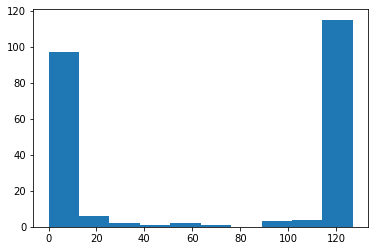

In [97]:

filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

gene_taken_off_sequence = [41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 64, 69, 7, 28, 2, 66, 36, 120, 21, 22]

features_df = pd.read_csv(network_features)
# print(accs[-27])
drop_index = gene_taken_off_sequence[:-26]
# print(len(drop_index))
X = ori_X.drop(columns=drop_index)

# X['degree'] = list(features_df['degree'])
# X['clustering_coef'] = list(features_df['clustering_coef'])
# X['weighted_degree'] = list(features_df['weighted_degree'])
# X['weighted_clustering_coef'] = list(features_df['weighted_clustering_coef'])

df = X
print(df)
correlations = np.corrcoef(df, df)[:231, :231]
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
            
# todo: insert code to do correlation distribution

# end todo

ex_df = pd.DataFrame(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])



df = pd.DataFrame()
de = G.degree(weight='weight')
cc = nx.clustering(G,weight='weight')

df['weighted_degree'] = np.array(de).T[1][:]
df['weighted_clustering_coef'] = cc.values()


thres_media = np.median(correlations)
G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        if correlations[i,j] > thres_media:
            G.add_edge(i, j)
de = G.degree()
cc = nx.clustering(G)

df['degree'] = np.array(de).T[1][:]
df['clustering_coef'] = cc.values()      
df.round(3)
print(df)
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G)

In [93]:

df = X
print(df)
correlations = np.corrcoef(df, df)[:231, :231]

for i in range(correlations.shape[0]):
    correlations[i][i]=0
    
correlations = correlations.flatten()
print(len(correlations))
len(list(filter(lambda a: a>0.99, correlations)))/2

         0        2      4       7        11     16       21      22     28   \
0      8.693    0.243  3.038   2.725    0.113  0.740    0.670   4.526  0.044   
1     22.395    0.392  0.185  12.568    0.510  0.603    8.116  27.136  0.000   
2     50.843    0.418  0.295   0.812    0.378  2.218    2.037  17.231  0.000   
3     66.151  332.090  1.566   5.638    0.364  3.301    3.954   9.239  0.005   
4     54.679    0.367  0.492   0.439    0.098  0.748    0.979  28.286  0.008   
..       ...      ...    ...     ...      ...    ...      ...     ...    ...   
226   78.057    0.542  0.194   0.791   63.541  0.224   26.979   3.057  0.061   
227  307.665    0.274  0.661   3.500  212.318  0.152  120.603   0.889  0.000   
228  224.079    0.853  0.000   6.981    0.391  0.016    4.868   2.877  0.027   
229    8.973    0.891  0.044   0.463   25.003  0.000   19.098   1.502  0.000   
230   52.029    0.264  0.382   2.029    8.704  1.313   10.495   2.126  0.418   

        32   ...    80      83      85 

5804.0

         0        2      4       7        11     16       21      22     28   \
0      8.693    0.243  3.038   2.725    0.113  0.740    0.670   4.526  0.044   
1     22.395    0.392  0.185  12.568    0.510  0.603    8.116  27.136  0.000   
2     50.843    0.418  0.295   0.812    0.378  2.218    2.037  17.231  0.000   
3     66.151  332.090  1.566   5.638    0.364  3.301    3.954   9.239  0.005   
4     54.679    0.367  0.492   0.439    0.098  0.748    0.979  28.286  0.008   
..       ...      ...    ...     ...      ...    ...      ...     ...    ...   
226   78.057    0.542  0.194   0.791   63.541  0.224   26.979   3.057  0.061   
227  307.665    0.274  0.661   3.500  212.318  0.152  120.603   0.889  0.000   
228  224.079    0.853  0.000   6.981    0.391  0.016    4.868   2.877  0.027   
229    8.973    0.891  0.044   0.463   25.003  0.000   19.098   1.502  0.000   
230   52.029    0.264  0.382   2.029    8.704  1.313   10.495   2.126  0.418   

        32   ...    80      83      85 

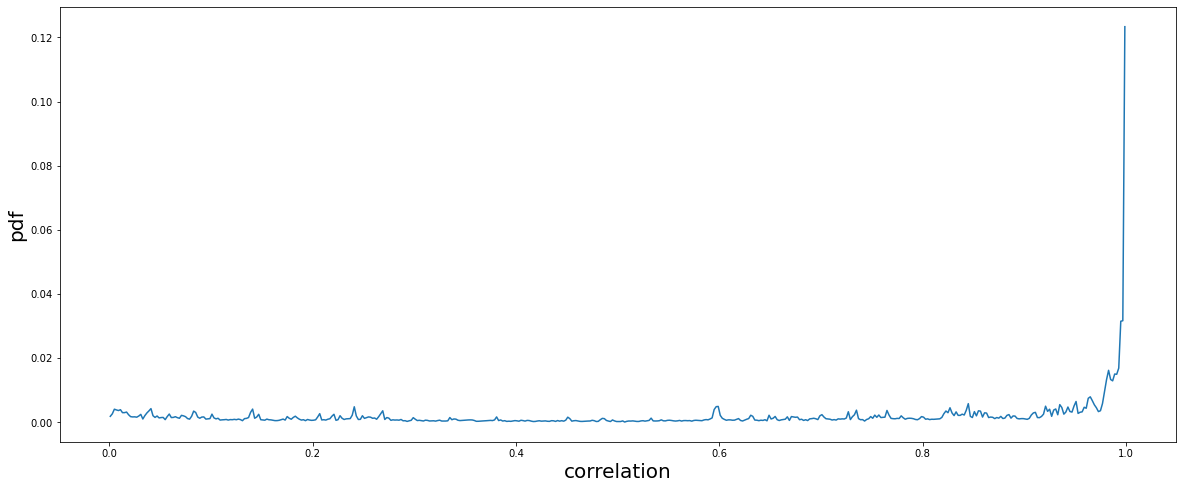

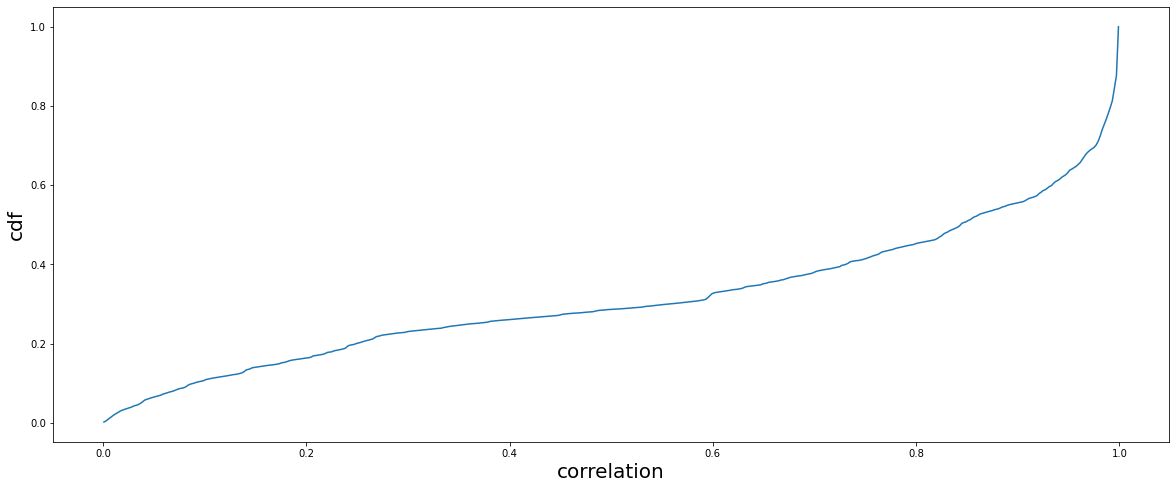

In [57]:

df = X
print(df)
correlations = np.corrcoef(df, df)[:231, :231]

for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
      

print(correlations)
correlations = correlations[~np.eye(correlations.shape[0],dtype=bool)].reshape(correlations.shape[0],-1)
print(correlations)
correlations = correlations.flatten()
print(len(correlations))



n = 500
s = np.asarray(correlations)   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
y = f(x)/len(correlations)

cdfy = np.cumsum(y)

plt.figure(figsize=(20,8))
plt.xlabel('correlation', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.plot(x, y)
plt.show()


plt.figure(figsize=(20,8))
plt.xlabel('correlation', fontsize=20)
plt.ylabel('cdf', fontsize=20)
plt.plot(x, cdfy)
plt.show()

In [95]:
x[490]
cdfy[490]

0.7239234138017194

In [70]:
# tt = []
# for i in range(20):
model = XGBClassifier()
kfold = KFold(n_splits=10,shuffle=True)

results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# tt.append(results.mean()*100)
y_pred = cross_val_predict(model, X, y, cv=kfold)
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

model = XGBClassifier()
model.fit(X, y)
# get importance
importance = model.feature_importances_
print(importance)
# print(np.mean(tt))

ValueError: Found input variables with inconsistent numbers of samples: [231, 500]

In [26]:
# print(len(importance))
X.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
      dtype='object', length=133)

[2, 115, 151, 236, 310, 743, 1052, 1085, 1328, 1597, 1902, 3121, 4036, 4377, 5415, 5637, 6271, 6309, 6416, 7454, 7850, 7950, 8959, 9165, 9188, 10522, 12102, 12331, 13683]
[0.01155364 0.0250545  0.010145   0.01683227 0.06003277 0.01184067
 0.00954726 0.01983062 0.02509011 0.24600585 0.04164509 0.25225544
 0.0145415  0.01349109 0.01440294 0.01131505 0.01172641 0.01211731
 0.0086916  0.02306288 0.01586654 0.01450279 0.01052362 0.01156684
 0.04310673 0.02147532 0.0090625  0.02381396 0.01089972]
['CXXC1', 'PPP1R16A', 'MAGED2', 'TMSB4Y', 'PTS', 'UBE2L3', 'RPL23', 'LRRC66', 'HPS5', 'GRIK5', 'GARS', 'ERGIC3', 'USP13', 'ASB8', 'NPTX1', 'RAP1GAP2', 'COPS2', 'RGL3', 'FLNA', 'CARD16', 'PRTFDC1', 'MT-ND1', 'IQCE', 'OR1L1', 'TMPRSS6', 'RPS15A', 'UBE2Z', 'LINC00672', 'NCEH1']


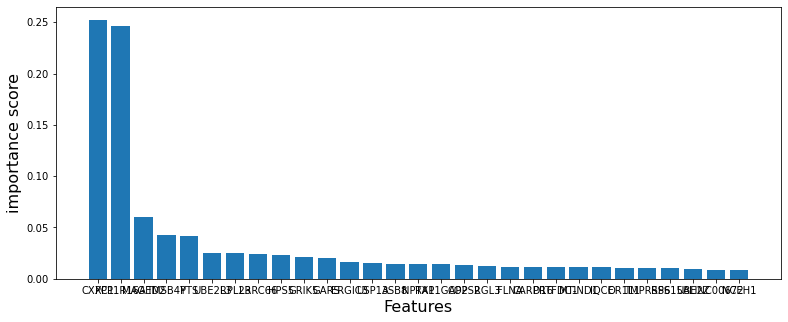

In [250]:

# patient_net_features = ['weighted\ndegree', 'degree', 'weighted\nclustering\ncoefficient', 'clustering\ncoefficient']
# patient_net_imp = [0.01989953, 0.0188352, 0.01702254, 0.01057105 ]
# top_genes_index = [32,48,11, 36, 22, 120,2, 21, 66]
# top_gene_importance = [0.28184038, 0.21213837, 0.13237873, 0.06341594, 0.05612952, 0.05351432, 0.04596942, 0.04433667, 0.04394828 ]
top_gene_importance = importance
top_genes_index = X.columns
genes_df = pd.read_csv(filterd_data)
# sorted(importance[:133])
id_symbol_lookup_df = pd.read_csv(id_symbol_lookup_file)
top_genes = []
# top_gene_importance = []
# importance_threshold = sorted(importance,reverse=True)[15]
for i in top_genes_index:
    top_genes.append(genes_df['Hugo_ID'][i])

print(top_genes)
print(top_gene_importance)
# id_symbol_lookup_df
# print(list(id_symbol_lookup_df['ID']))
# print(list(id_symbol_lookup_df['Hugo_Symbol']))
ids = list(id_symbol_lookup_df['ID'])
symbols = list(id_symbol_lookup_df['Hugo_Symbol'])
top_genes_symbol = []
for i in top_genes:
    top_genes_symbol.append(symbols[i])

top_genes_df = pd.DataFrame({'Hugo_Symbol':top_genes_symbol,'importance':top_gene_importance}) 

top_genes_df = top_genes_df.sort_values(by='importance',axis=0,ascending=[False])

plt.figure(figsize=(13,5))
plt.bar(list(top_genes_df['Hugo_Symbol']), list(top_genes_df['importance']))
plt.ylabel('importance score', fontsize=16)
plt.xlabel('Features', fontsize=16)
print(list(top_genes_df['Hugo_Symbol']))

confusion_matrix_df and classification_report

       0     1     2
0  113.5   2.1   1.4
1    6.8  67.2   0.0
2    4.2   1.3  34.5


NameError: name 'y' is not defined

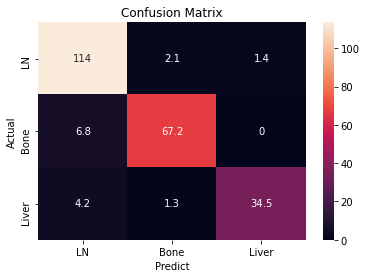

In [3]:

class2idx = {
    'LN':0,
    'Bone':1,
    'Liver':2
}

idx2class = {v: k for k, v in class2idx.items()}
# print(idx2class)

mat = [[113.5,2.1,1.4],
        [6.8,67.2,0],
        [4.2,1.3,34.5]]
print(pd.DataFrame(mat))
confusion_matrix_df = pd.DataFrame(mat).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True, fmt=".3g").set(xlabel="Predict", ylabel = "Actual",title="Confusion Matrix")
print(classification_report(y, y_pred))

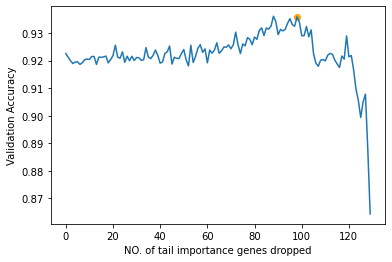

In [18]:
fake_acc = [0.92255435, 0.92121377, 0.91990036, 0.91893116, 0.91946558,
       0.9195471 , 0.91861413, 0.91921196, 0.92032609, 0.92056159,
       0.92042572, 0.92148551, 0.92145833, 0.91859601, 0.92125   ,
       0.92118659, 0.92131341, 0.92163949, 0.91917572, 0.92036232,
       0.9217663 , 0.92557971, 0.92125906, 0.92084239, 0.92317029,
       0.91938406, 0.9215942 , 0.91993659, 0.92156703, 0.92001812,
       0.92111413, 0.92105978, 0.92008152, 0.92029891, 0.92469203,
       0.92125906, 0.92070652, 0.92188406, 0.92380435, 0.92184783,
       0.91906703, 0.91951087, 0.92258152, 0.92318841, 0.92527174,
       0.91873188, 0.92117754, 0.92080616, 0.9207337 , 0.92256341,
       0.92401268, 0.92032609, 0.91806159, 0.92556159, 0.91929348,
       0.92153986, 0.92447464, 0.92575181, 0.92298007, 0.92423007,
       0.91918478, 0.92382246, 0.92269928, 0.92378623, 0.92645833,
       0.92264493, 0.92351449, 0.92492754, 0.9248279 , 0.92567935,
       0.92429348, 0.92572464, 0.93031703, 0.92576993, 0.92254529,
       0.92601449, 0.92533514, 0.92833333, 0.92772645, 0.92576993,
       0.92853261, 0.92771739, 0.93093297, 0.93185688, 0.92907609,
       0.93181159, 0.93143116, 0.93251812, 0.93608152, 0.93416667,
       0.92942029, 0.93131341, 0.93076087, 0.93133152, 0.93353261,
       0.93520471, 0.93304348, 0.93245471, 0.93586159, 0.93400362,
       0.92901268, 0.9290308 , 0.93237319, 0.92862319, 0.93113225,
       0.92246377, 0.91908514, 0.91794384, 0.92012681, 0.92036232,
       0.91990036, 0.92192935, 0.92259964, 0.92228261, 0.92018116,
       0.91878623, 0.91750906, 0.92164855, 0.92053442, 0.92895833,
       0.9213587 , 0.92184783, 0.91658514, 0.90961051, 0.90548007,
       0.89933877, 0.90495471, 0.90782609, 0.88783514, 0.86438406]
plt.figure()
plt.xlabel('NO. of tail importance genes dropped')
plt.ylabel('Validation Accuracy')
plt.plot(np.arange(len(fake_acc)), fake_acc)
plt.scatter(98, fake_acc[98], color = 'orange')
# plt.scatter(123, accs[123], color = 'y')
plt.show()